In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score
from tensorflow.keras import regularizers
from scipy.stats import ks_2samp
# load data
data = pd.read_csv("archive\creditcard.csv")
X = data.drop('Class', axis=1).values
y = data['Class'].values

# plot the class distribution
pd.value_counts(data['Class'])

C:\Users\ayyhh\AppData\Local\Temp\ipykernel_9464\674577417.py:17: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.value_counts(data['Class'])


Class
0    284315
1       492
Name: count, dtype: int64

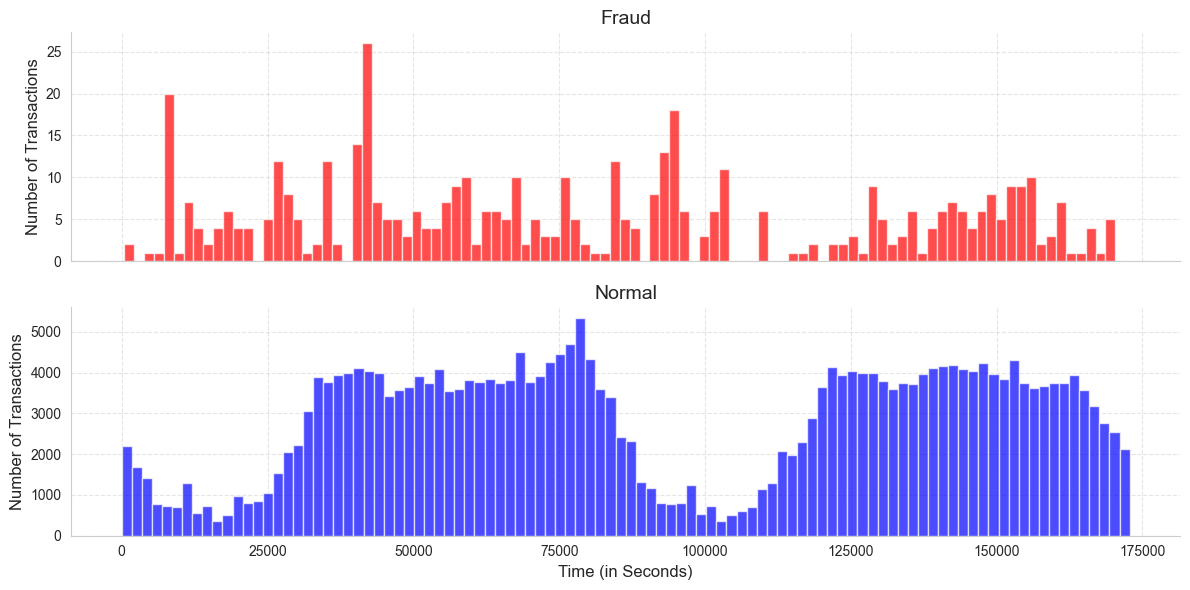

In [2]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12, 6))

bins = 100

# Plotting for Fraud transactions
ax1.hist(data.Time[data.Class == 1], bins=bins, color='red', alpha=0.7)
ax1.set_title('Fraud', fontsize=14)
ax1.set_ylabel('Number of Transactions', fontsize=12)
ax1.grid(True, linestyle='--', alpha=0.5)

# Plotting for Normal transactions
ax2.hist(data.Time[data.Class == 0], bins=bins, color='blue', alpha=0.7)
ax2.set_title('Normal', fontsize=14)
ax2.set_xlabel('Time (in Seconds)', fontsize=12)
ax2.set_ylabel('Number of Transactions', fontsize=12)
ax2.grid(True, linestyle='--', alpha=0.5)

# Remove top and right spines
for ax in [ax1, ax2]:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()


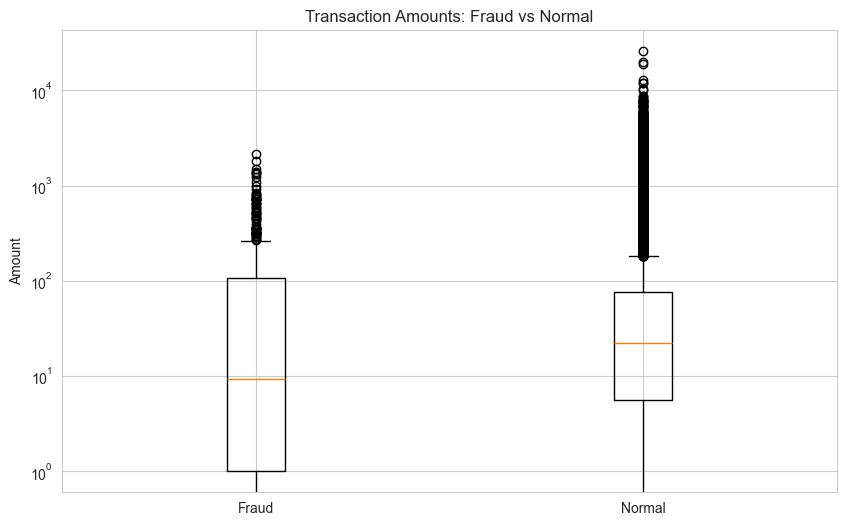

In [3]:
plt.figure(figsize=(10, 6))
plt.boxplot([data[data["Class"]==1]["Amount"], data[data["Class"]==0]["Amount"]], 
            labels=['Fraud', 'Normal'])

plt.title('Transaction Amounts: Fraud vs Normal')
plt.ylabel('Amount')
plt.yscale('log')
plt.show()

In [4]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)

# normalize data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [5]:
model = tf.keras.Sequential(
    [
        # Adjusted number of neurons
        tf.keras.layers.Dense(128, activation="relu", input_shape=(X.shape[-1],),
                              kernel_regularizer=regularizers.l2(0.001)),  # L2 regularization
        tf.keras.layers.Dropout(0.2),  # Adjusted dropout rate
        tf.keras.layers.Dense(64, activation="relu",
                              kernel_regularizer=regularizers.l2(0.001)),  # L2 regularization
        tf.keras.layers.Dropout(0.2),  # Adjusted dropout rate
        tf.keras.layers.Dense(1, activation="sigmoid"),
    ]
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               3968      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 12289 (48.00 KB)
Trainable params: 12289 (48.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [6]:
metrics = [
    tf.keras.metrics.FalseNegatives(name="fn"),
    tf.keras.metrics.FalsePositives(name="fp"),
    tf.keras.metrics.TrueNegatives(name="tn"),
    tf.keras.metrics.TruePositives(name="tp"),
    tf.keras.metrics.Precision(name="precision"),
    tf.keras.metrics.Recall(name="recall"),
]

In [7]:
# compile the model
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics = metrics)

# configure early stopping
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

# calculate class weights
neg, pos = np.bincount(y_train)
total = neg + pos
class_weight = {0: 1, 1: 5}

# train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, callbacks=[es], class_weight=class_weight)


Epoch 1/100
4006/4006 [==============================] - 61s 14ms/step - loss: 0.1708 - fn: 126.0000 - fp: 679.0000 - tn: 127263.0000 - tp: 95.0000 - precision: 0.1227 - recall: 0.4299 - val_loss: 0.0909 - val_fn: 16.0000 - val_fp: 14.0000 - val_tn: 42633.0000 - val_tp: 58.0000 - val_precision: 0.8056 - val_recall: 0.7838
Epoch 2/100
4006/4006 [==============================] - 53s 13ms/step - loss: 0.0801 - fn: 52.0000 - fp: 27.0000 - tn: 127915.0000 - tp: 169.0000 - precision: 0.8622 - recall: 0.7647 - val_loss: 0.0544 - val_fn: 13.0000 - val_fp: 15.0000 - val_tn: 42632.0000 - val_tp: 61.0000 - val_precision: 0.8026 - val_recall: 0.8243
Epoch 3/100
4006/4006 [==============================] - 51s 13ms/step - loss: 0.0512 - fn: 46.0000 - fp: 25.0000 - tn: 127917.0000 - tp: 175.0000 - precision: 0.8750 - recall: 0.7919 - val_loss: 0.0349 - val_fn: 10.0000 - val_fp: 15.0000 - val_tn: 42632.0000 - val_tp: 64.0000 - val_precision: 0.8101 - val_recall: 0.8649
Epoch 4/100
4006/4006 [=======